## Introduction

We will go through each step to build the \[\[7,1,3\]\] color code, also known as the Stane Code.



## Encoding

We can first start by preparing the logical qubit basis state. This circuit will prepare the logical basis state $|0\rangle_L$ which corresponds to the state/code word:


$$
\begin{align}
|0\rangle_L & = |0000000\rangle+|1010101\rangle+|0110011\rangle+|1100110\rangle \\
& +|0001111\rangle+|1011010\rangle+|0111100\rangle+|1101001\rangle, \notag \\
|1\rangle_L & = X_{1111111}|0\rangle_L \\
& = |1111111\rangle+|0101010\rangle+|1001100\rangle+|0011001\rangle \notag \\
& +|1110000\rangle+|0100101\rangle+|1000011\rangle+|0010110\rangle).
\end{align}
$$

Note that Qiskit uses little-endianness whereas this state uses big-endianness, meaning the order of the 1's and 0's are reversed. So, we're actually preparing a state which is written as the reverse of each of these individual states.

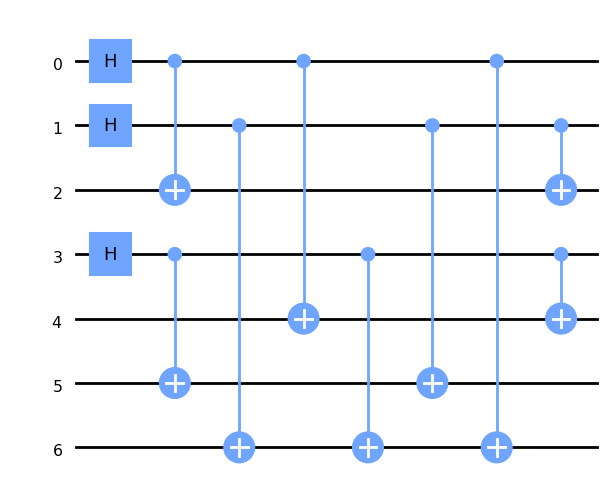

In [10]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

qreg_q = QuantumRegister(7, '')

# Encoding circuit to create the logical basis states
encodingcircuit = QuantumCircuit(qreg_q)
encodingcircuit.h(qreg_q[0])
encodingcircuit.h(qreg_q[1])
encodingcircuit.h(qreg_q[3])
encodingcircuit.cx(qreg_q[0], qreg_q[2])
encodingcircuit.cx(qreg_q[3], qreg_q[5])
encodingcircuit.cx(qreg_q[1], qreg_q[6])
encodingcircuit.cx(qreg_q[0], qreg_q[4])
encodingcircuit.cx(qreg_q[3], qreg_q[6])
encodingcircuit.cx(qreg_q[1], qreg_q[5])
encodingcircuit.cx(qreg_q[0], qreg_q[6])
encodingcircuit.cx(qreg_q[1], qreg_q[2])
encodingcircuit.cx(qreg_q[3], qreg_q[4])
encodingcircuit.draw('mpl')

Now, let's verify if we created the right logical state.

In [11]:
from qiskit.quantum_info import Statevector

# Returns the output statevector of the given circuit
statevec = Statevector.from_instruction(encodingcircuit.reverse_bits())
statevec.draw(output = 'latex')

<IPython.core.display.Latex object>

As we can see, this is indeed the correct $|0\rangle_L$ logical state we want to prepare! However, the circuit taken from Quantinuum paper looks different. What's going on here? The extra 8th qubit here is to make sure such a logical state preparation subroutine is fault-tolerant.

<img src="EncodingCircuit_Quantinuum.png" alt="drawing" width="400"/>

Let's try their circuit implementation.

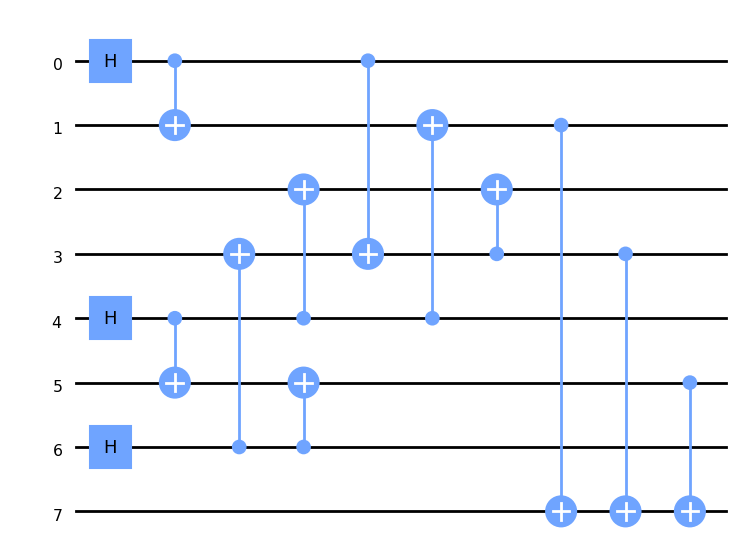

In [13]:
qreg = QuantumRegister(8, "")

# Encoding circuit to create the logical basis states
quantinuum_circuit = QuantumCircuit(qreg)
quantinuum_circuit.h(qreg[0])
quantinuum_circuit.h(qreg[4])
quantinuum_circuit.h(qreg[6])
quantinuum_circuit.cx(qreg[0], qreg[1])
quantinuum_circuit.cx(qreg[4], qreg[5])
quantinuum_circuit.cx(qreg[6], qreg[3])
quantinuum_circuit.cx(qreg[4], qreg[2])
quantinuum_circuit.cx(qreg[6], qreg[5])
quantinuum_circuit.cx(qreg[0], qreg[3])
quantinuum_circuit.cx(qreg[4], qreg[1])
quantinuum_circuit.cx(qreg[3], qreg[2])

quantinuum_circuit.cx(qreg[1], qreg[7])
quantinuum_circuit.cx(qreg[3], qreg[7])
quantinuum_circuit.cx(qreg[5], qreg[7])
quantinuum_circuit.draw('mpl')

In [14]:
quantinuum_statevec = Statevector.from_instruction(quantinuum_circuit.reverse_bits())
quantinuum_statevec.draw(output = 'latex')

<IPython.core.display.Latex object>

These still look different from previous results. So what's happening here is Quantinuum's paper using a different index system (right below) to label their physical qubits compare to ours (left below).

A  | B
- | - 
![alt](yourimg1.jpg) | ![alt](yourimg2.jpg)


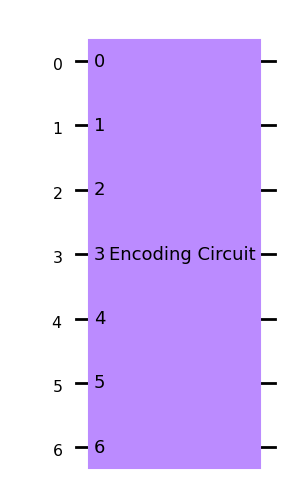

In [16]:
encodeGate = encodingcircuit.to_instruction(label='Encoding Circuit')

encoder = QuantumCircuit(qreg_q)
encoder.append(encodeGate, qreg_q) 
encoder.draw('mpl')

XXXXIII (logical state is an eigenstate)
IXXIIXX (logical state is an eigenstate)
XIXIXIX (logical state is an eigenstate)
ZZZZIII (logical state is an eigenstate)
IZZIIZZ (logical state is an eigenstate)
ZIZIZIZ (logical state is an eigenstate)
stabilizers 'XXXXIII' and 'IXXIIXX'  commute
stabilizers 'XXXXIII' and 'XIXIXIX'  commute
stabilizers 'XXXXIII' and 'ZZZZIII'  commute
stabilizers 'XXXXIII' and 'IZZIIZZ'  commute
stabilizers 'XXXXIII' and 'ZIZIZIZ'  commute
stabilizers 'IXXIIXX' and 'XIXIXIX'  commute
stabilizers 'IXXIIXX' and 'ZZZZIII'  commute
stabilizers 'IXXIIXX' and 'IZZIIZZ'  commute
stabilizers 'IXXIIXX' and 'ZIZIZIZ'  commute
stabilizers 'XIXIXIX' and 'ZZZZIII'  commute
stabilizers 'XIXIXIX' and 'IZZIIZZ'  commute
stabilizers 'XIXIXIX' and 'ZIZIZIZ'  commute
stabilizers 'ZZZZIII' and 'IZZIIZZ'  commute
stabilizers 'ZZZZIII' and 'ZIZIZIZ'  commute
stabilizers 'IZZIIZZ' and 'ZIZIZIZ'  commute


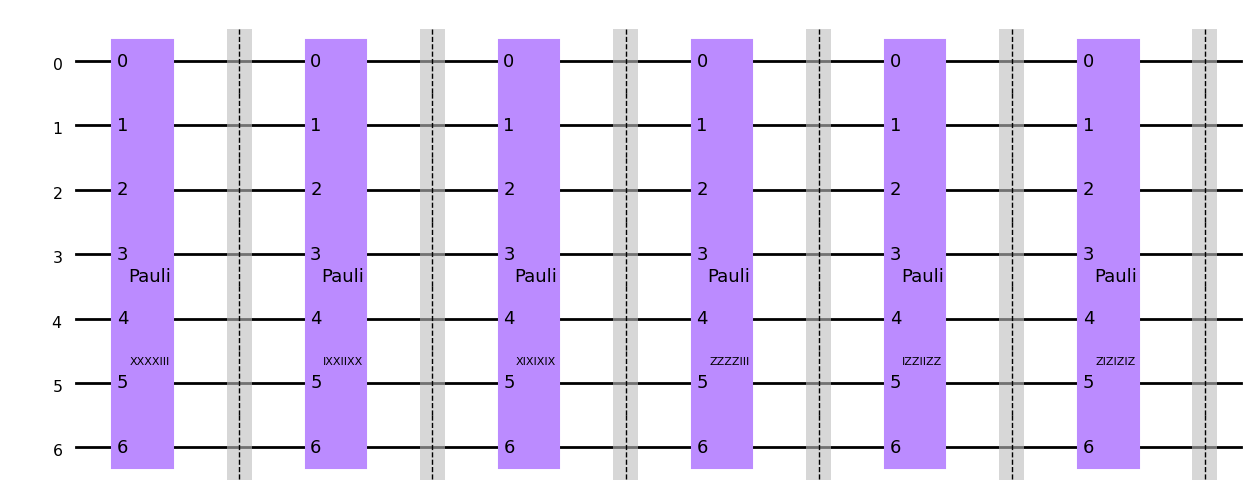

In [18]:
from qiskit.quantum_info import Operator

stabilizer_strings = [
    "XXXXIII",
    "IXXIIXX",
    "XIXIXIX",
    "ZZZZIII",
    "IZZIIZZ",
    "ZIZIZIZ"
]

stabilizer_circuits = []

compiled_stabilizercircuit = QuantumCircuit(qreg_q)
for stabilizer_string in stabilizer_strings:
    stabilizercircuit = QuantumCircuit(qreg_q)
    stabilizercircuit.pauli(stabilizer_string, qreg_q)
    stabilizercircuit.barrier(qreg_q)

    # check that logical zero vector is an eigenstate of this stabilizer
    test_statevec = Statevector.from_instruction(encodingcircuit) # encode statevector
    tested_statevec = Statevector.from_instruction(encodingcircuit).evolve(stabilizercircuit) # apply this stabilizer
    print(f"{stabilizer_string} (logical state is {'' if tested_statevec.equiv(test_statevec) else 'not '}an eigenstate)")

    stabilizer_circuits.append(stabilizercircuit)
    compiled_stabilizercircuit &= stabilizercircuit

for si in range(len(stabilizer_circuits)-1):
    stabilizer_i = Operator(stabilizer_circuits[si])

    for sj in range(si+1, len(stabilizer_circuits)):
        stabilizer_j = Operator(stabilizer_circuits[sj])

        commutator = stabilizer_i.compose(stabilizer_j) - stabilizer_j.compose(stabilizer_i)
        commutes = stabilizer_i.compose(stabilizer_j) == stabilizer_j.compose(stabilizer_i)
        print(f"stabilizers '{stabilizer_strings[si]}' and '{stabilizer_strings[sj]}' {'' if commutes else 'do not'} commute")

compiled_stabilizercircuit.draw("mpl")

Now we can measure the encoding circuit using the 3 CNOTs. This constitutes a measurement in the logical Z basis.

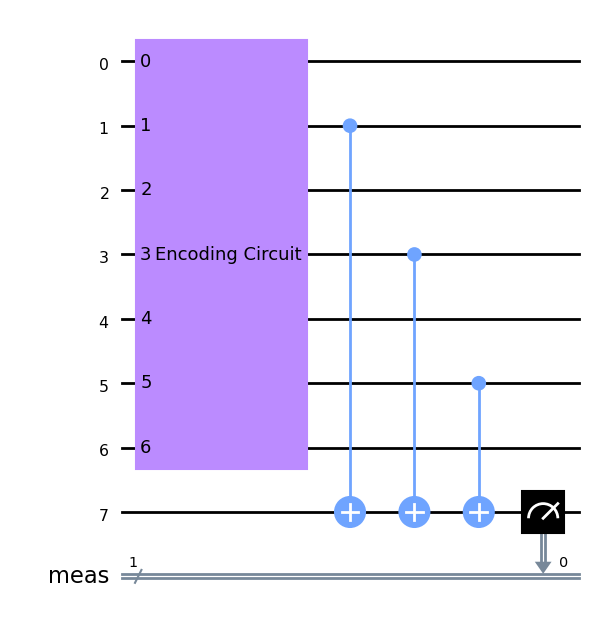

In [20]:
qreg_m = QuantumRegister(8, '')
creg_m = ClassicalRegister(1, name='meas')
meascircuit = QuantumCircuit(qreg_m, creg_m)
meascircuit.append(encodeGate, qreg_m[:7])
meascircuit.cx(control_qubit=qreg_m[1], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[3], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[5], target_qubit=qreg_m[7])
meascircuit.measure(7, 0)
meascircuit.draw('mpl')

## Decoding

---

## References

1. 